# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(feat_info.shape)
feat_info

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
def parse_string(x):
    # x starts out as "[-1, 0]" or "[-1, XX]"
    x = x.strip('[]').split(',')
    # x is now ['-1', '0'] or ['-1', 'XX']
    if x == ['']:
        x = []
    else:
        x = list(map(convert_to_int_if_possible, x))
    # x is now [-1, 0] or [-1, 'XX']
    return x
    
def convert_to_int_if_possible(x):
    try:
        return int(x.strip())
    except ValueError:
        return x.strip()

feat_info['missing_or_unknown_list'] = list(map(parse_string, feat_info['missing_or_unknown']))
feat_info

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_list
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]


In [6]:
for attribute in feat_info['attribute'].values:
    missing_or_unknown_list = feat_info.loc[feat_info['attribute']==attribute, 'missing_or_unknown_list'].tolist()[0]
    azdias.loc[azdias[attribute].isin(missing_or_unknown_list), attribute] = np.nan
        
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<Container object of 85 artists>

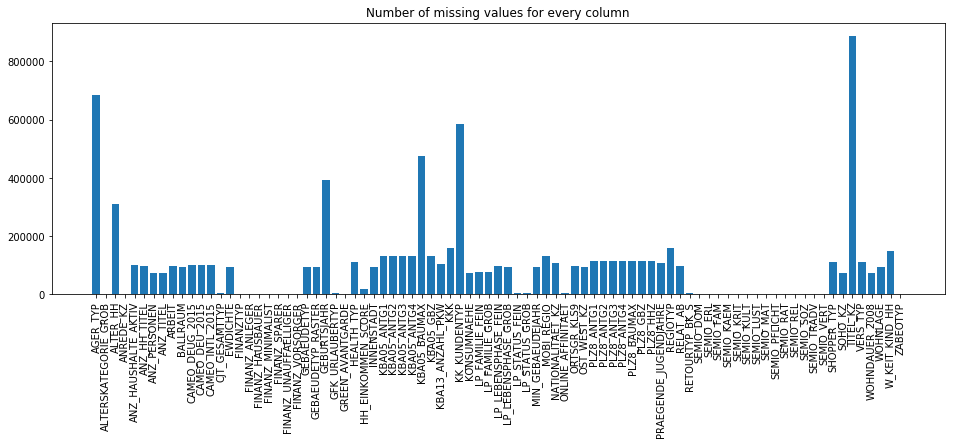

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = azdias.isna().sum(axis=0)
plt.figure(figsize=[16, 5])
plt.xticks(rotation=90)
plt.title("Number of missing values for every column")
plt.bar(missing_data.index, missing_data)

In [8]:
# Investigate patterns in the amount of missing data in each column.

print(missing_data.sort_values().to_string())

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
CJT_GESAMTTYP              4854
HH_EINKO

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([      0. ,   88906.1,  177812.2,  266718.3,  355624.4,  444530.5,
         533436.6,  622342.7,  711248.8,  800154.9,  889061. ]),
 <a list of 10 Patch objects>)

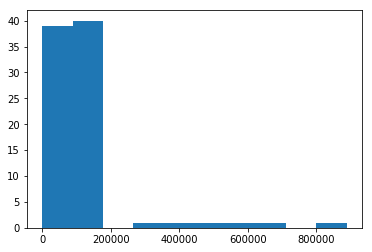

In [9]:
plt.hist(missing_data.tolist())

(array([ 24.,   1.,   6.,   0.,   1.,   0.,   7.,  40.,   1.,   3.,   2.]),
 array([     0,      1,   3000,   6000,  16000,  32000,  64000,  80000,
        160000, 320000, 640000, 960000]),
 <a list of 11 Patch objects>)

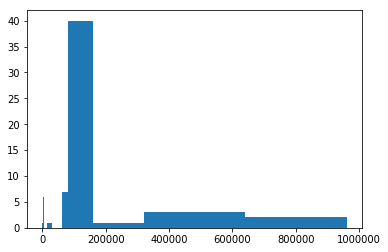

In [10]:
plt.hist(missing_data.tolist(), bins=[0, 1, 3000, 6000, 16000, 32000, 64000, 80000, 160000, 320000, 640000, 960000])

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#79 of the 85 features had less than 20% missing values. remove the 6 outlier columns.
missing_data.sort_values().iloc[-6:]

ALTER_HH        310267
GEBURTSJAHR     392318
KBA05_BAUMAX    476524
KK_KUNDENTYP    584612
AGER_TYP        685843
TITEL_KZ        889061
dtype: int64

In [12]:
columns_to_drop = missing_data.sort_values().iloc[-6:].index.tolist()
azdias_processed = azdias.drop(columns_to_drop, axis=1)
azdias_processed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Looking at the data, the number of missing data for each column is clustered around several groups. 

1. 24 columns had no missing data at all. These included all of the FINANZ and SEMIO columns, as well as a few others.
2. An additional column "ALTERSKATEGORIE_GROB" had only 2881 (0.3%) missing values.
3. An additional 6 columns each had exactly 4854 (0.5%) missing values. These columns (GFK_URLAUBERTYP, LP_STATUS_GROB, LP_STATUS_FEIN, ONLINE_AFFINITAET, RETOURTYP_BK_S) may be related.
4. An additional column "HH_EINKOMMEN_SCORE" had 18348 (2.1%) missing values. 
5. 47 columns had between 73499 (8.2%) and 158064 (17.7%) missing values. These columns appear to be clustered into several subgroups (7 around 73k-78k, 9 around 93k-95k, 9 around 97k-100k, 3 around 105k-109k, 3 at 111196, 7 at 116515 (PLZ columns), 6 at 133324 (KBA05 columns), and 3 around 148k-158k).
6. The last 6 columns had between 310267 (34.8%) and 889061 (99.8%) missing values. THese columns are (ALTER_HH, GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, AGER_TYP, TITEL_KZ).

Hence, I believe the best recommended course of action is only to drop the columns in the last group (group 6). However, a more agressive strategy would also drop columns in some or all of the subgroups in group 5.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

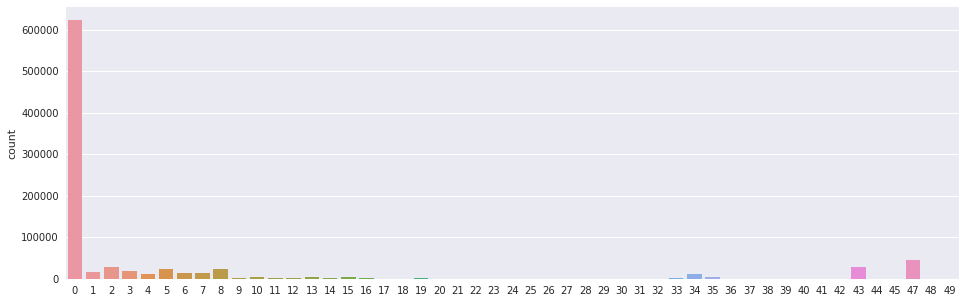

In [13]:
# How much data is missing in each row of the dataset?
missing_row_data = azdias_processed.isna().sum(axis=1)
sns.set(rc={'figure.figsize':(16,5)})
sns.countplot(x=missing_row_data.index, data=missing_row_data)

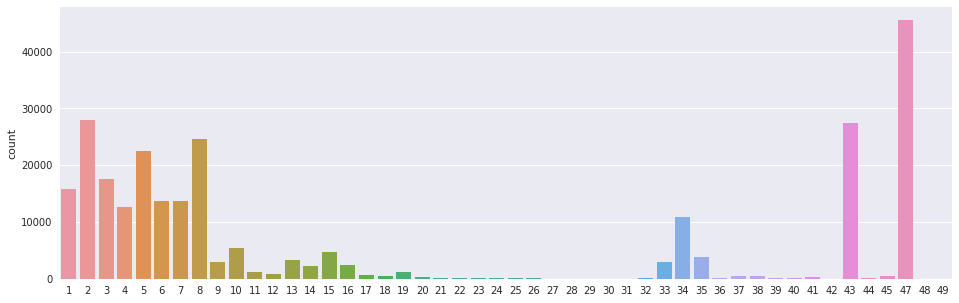

In [14]:
missing_row_data_nonzero = missing_row_data.loc[missing_row_data!=0]
sns.countplot(x=missing_row_data_nonzero.index, data=missing_row_data_nonzero)

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_row_data_A = missing_row_data.loc[missing_row_data<27]
missing_row_data_B = missing_row_data.loc[missing_row_data>=27]
azdias_processed_A = azdias_processed.loc[missing_row_data_A.index]
azdias_processed_B = azdias_processed.loc[missing_row_data_B.index]
azdias_processed_A.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [23]:
azdias_processed.isna().sum(axis=0)[azdias_processed.isna().sum(axis=0)==0]

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

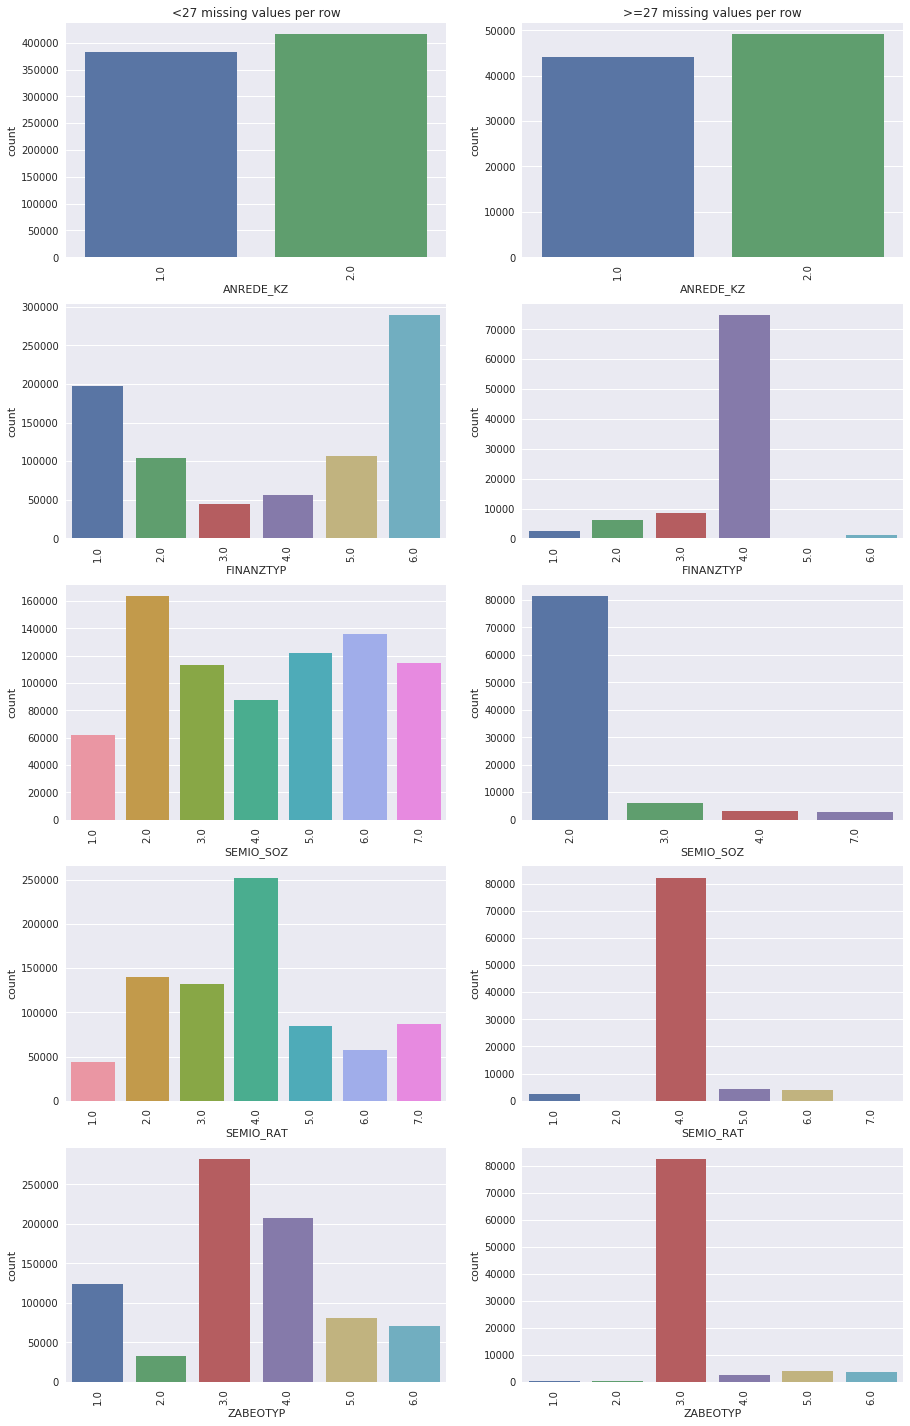

In [56]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# I will compare distributions with the following five columns: ANREDE_KZ, FINANZTYP, SEMIO_SOZ, SEMIO_RAT, ZABEOTYP
# These columns refer to gender, financial type, social-mindedness, rationality, and energy consumption, respectively.
# I chose these columns because they do not contain any NaNs and appear to be independent of each other
columns_to_examine = ['ANREDE_KZ', 'FINANZTYP', 'SEMIO_SOZ', 'SEMIO_RAT', 'ZABEOTYP']

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(15, 25))

for cnt, ax in enumerate(axes):
    column_to_examine = columns_to_examine[cnt]
    left_axis = ax[0]
    right_axis = ax[1]
    
    if cnt == 0:
        left_axis.set_title('<27 missing values per row')
        right_axis.set_title('>=27 missing values per row')
    
    order_left = np.sort(azdias_processed_A[column_to_examine].value_counts().index)
    order_right = np.sort(azdias_processed_B[column_to_examine].value_counts().index)
    
    sns.countplot(x=column_to_examine, data=azdias_processed_A, ax=left_axis, order=order_left)
    sns.countplot(x=column_to_examine, data=azdias_processed_B, ax=right_axis, order=order_right)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

#### Discussion 1.1.3: Assess Missing Data in Each Row

I compared distributions with the following five columns: 
* ANREDE_KZ: gender
* FINANZTYP: financial type
* SEMIO_SOZ: social-mindedness
* SEMIO_RAT: rationality
* ZABEOTYP: energy consumption. 
I chose these columns because they do not contain any NaNs and appear to be independent of each other.

**ANREDE_KZ**
Gender distribution looks quite similar, with both populations having slightly more females than males.

**FINANZTYP**
Financial type was very dissimilar. The general population was mostly types 1 and 6 (low financial interest and inconspicuous), but all types were well represented. The high-NaN subset was overwhelmingly type 4 (be prepared).

**SEMIO_SOZ**
The general population had a good representation of all levels of social-mindedness. The high-NaN subset was overwhelmingly type 2 (very high affinity for social-mindedness).

**SEMIO_RAT**
The general population had a good representation of all levels of rationality. The high-NaN subset was overwhelmingly type 4 (average affinity for rationality).

**ZABEOTYP**
The general population had a good representation of all levels of energy consumption, except possibly type 2 (smart). The high-NaN subset was overwhelmingly type 3 (fair supplied).

**Conclusion**
It is unclear to me why the distributions of the high-NaN subset is so different from that of the general population. It could be that individuals with high NaN values tend to cluster around a very specific individual personality type or living situation.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
# With the dropped columns
feat_info.groupby('type').size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

In [18]:
# Without the dropped columns
feat_info_dropped_columns = feat_info.loc[~feat_info['attribute'].isin(columns_to_drop)]
feat_info_dropped_columns.groupby('type').size()

type
categorical    18
mixed           6
numeric         6
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categoricals = feat_info_dropped_columns.loc[feat_info['type']=='categorical', 'attribute'].tolist()
for categorical_type in categoricals:
    print(categorical_type, ":", azdias_processed_A[categorical_type].unique(), ":", 
          len(azdias_processed_A[categorical_type].unique()))

ANREDE_KZ : [ 2.  1.] : 2
CJT_GESAMTTYP : [  5.   3.   2.   4.   1.   6.  nan] : 7
FINANZTYP : [ 1.  6.  5.  2.  4.  3.] : 6
GFK_URLAUBERTYP : [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan] : 13
GREEN_AVANTGARDE : [ 0.  1.] : 2
LP_FAMILIE_FEIN : [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.] : 12
LP_FAMILIE_GROB : [  3.   1.  nan   5.   2.   4.] : 6
LP_STATUS_FEIN : [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan] : 11
LP_STATUS_GROB : [  1.   2.   4.   5.   3.  nan] : 6
NATIONALITAET_KZ : [  1.   3.   2.  nan] : 4
SHOPPER_TYP : [  3.   2.   1.   0.  nan] : 5
SOHO_KZ : [ 1.  0.] : 2
VERS_TYP : [  2.   1.  nan] : 3
ZABEOTYP : [ 5.  3.  4.  1.  6.  2.] : 6
GEBAEUDETYP : [ 8.  1.  3.  2.  6.  4.  5.] : 7
OST_WEST_KZ : ['W' 'O'] : 2
CAMEO_DEUG_2015 : ['8' '4' '2' '6' '1' '9' '5' '7' nan '3'] : 10
CAMEO_DEU_2015 : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' 

In [20]:
binary_categoricals = {} # keys are the category names, values = True if the category values are numerical
multi_level_categoricals = []
for categorical_type in categoricals:
    # get unique values, ignoring NaN
    unique_values = azdias_processed_A.loc[~azdias_processed_A[categorical_type].isna(), categorical_type].unique()
    if len(unique_values) == 2:
        is_numerical = isinstance(unique_values[0], (int, float)) and isinstance(unique_values[1], (int, float))
        binary_categoricals[categorical_type] = is_numerical
    else:
        multi_level_categoricals.append(categorical_type)
                                                                                 
print("Binary categories are as follows:")
for binary_category in binary_categoricals:
    is_numerical = binary_categoricals[binary_category]
    if is_numerical:
        print('*', binary_category)
    else:
        print('*', binary_category, "(Note: this needs to be re-encoded as numbers)")
                                                                                 
print()
print("Multi-level categories are as follows:")
for multi_level_category in multi_level_categoricals:
    print('*', multi_level_category)

Binary categories are as follows:
* ANREDE_KZ
* GREEN_AVANTGARDE
* SOHO_KZ
* VERS_TYP
* OST_WEST_KZ (Note: this needs to be re-encoded as numbers)

Multi-level categories are as follows:
* CJT_GESAMTTYP
* FINANZTYP
* GFK_URLAUBERTYP
* LP_FAMILIE_FEIN
* LP_FAMILIE_GROB
* LP_STATUS_FEIN
* LP_STATUS_GROB
* NATIONALITAET_KZ
* SHOPPER_TYP
* ZABEOTYP
* GEBAEUDETYP
* CAMEO_DEUG_2015
* CAMEO_DEU_2015


*Binary categoricals*
* ANREDE_KZ
* GREEN_AVANTGARDE
* SOHO_KZ
* VERS_TYP
* OST_WEST_KZ
Note: OST_WEST_KZ needs to be re-encoded as numbers.

*Multi-level categoricals*
* CJT_GESAMTTYP
* FINANZTYP
* GFK_URLAUBERTYP
* LP_FAMILIE_FEIN
* LP_FAMILIE_GROB
* LP_STATUS_FEIN
* LP_STATUS_GROB
* NATIONALITAET_KZ
* SHOPPER_TYP
* ZABEOTYP
* GEBAEUDETYP
* CAMEO_DEUG_2015
* CAMEO_DEU_2015

In [21]:
binary_categoricals_processed = list(binary_categoricals.keys()).copy()
multi_level_categoricals_processed = multi_level_categoricals.copy()

# Re-encode categorical variable(s) to be kept in the analysis.
azdias_processed_reenconded = azdias_processed_A.copy() # Make new copy

# Convert OST_WEST_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015 to integer values
for cat_name in ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']:
    cat_int = cat_name + '_INT'
    cat_values = azdias_processed_reenconded[cat_name].unique() # List of all unique values
    cat_values = [x for x in cat_values if pd.notnull(x)] # Remove nan's and sort
    # Ex: if possible values are ['W' 'O'], map 'W' to 0 and 'O' to 1
    azdias_processed_reenconded[cat_int] = azdias_processed_reenconded[cat_name].map(
        lambda x: cat_values.index(x), na_action = 'ignore')
    # Remove original category from dataframe
    azdias_processed_reenconded.drop(cat_name, axis=1, inplace=True)
    # Switch out categories
    if cat_name in binary_categoricals:
        binary_categoricals_processed[binary_categoricals_processed.index(cat_name)] = cat_int
    if cat_name in multi_level_categoricals:
        multi_level_categoricals_processed[multi_level_categoricals_processed.index(cat_name)] = cat_int

# Impute Nan's
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)
azdias_processed_imputed = pd.DataFrame(imp.fit_transform(azdias_processed_reenconded))
azdias_processed_imputed.columns = azdias_processed_reenconded.columns
    
### The following code has been commented out ###
### One-hot-encoding is difficult for the following reasons:
###  * it doesn't keep track of column names
###  * The customer demographic data might only have a subset of values of the population data
###  * so the one-hot-encoded customer demographic data has smaller number of columns
###  * and without column names, no way to correlate between the two.
###  * I could write a custom one-hot-encoder to keep track of and correlate names,
###  * but the "juice isn't worth the squeeze", so they say.
# One-hot-encode multi-level categories
#column_mask = []
#for column_name in azdias_processed_imputed.columns:
#    column_mask.append(column_name in multi_level_categoricals_processed)
#    
#enc = OneHotEncoder(handle_unknown='ignore', categorical_features=column_mask)
#
#azdias_processed_onehot = enc.fit_transform(azdias_processed_imputed)

# Will just drop those columns instead.
azdias_processed_drop = azdias_processed_imputed.drop(multi_level_categoricals_processed, axis=1)

In [22]:
print(azdias_processed_imputed.shape)
print(azdias_processed_drop.shape)
azdias_processed_drop

(798020, 79)
(798020, 66)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_INT
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.0
5,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0.0
6,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0.0
7,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0.0
8,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,2.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0.0
9,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0.0,2.0,...,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features

After initially dropping the six features with the highest number of missing data, I kept all remaining categorical features. There were 6 binary categorical features and 13 multi-level categorical features. 

Of the 6 binary categorical features, 5 featured numeric data while 1 (OST_WEST_KZ) featured string data. I therefore mapped the string values into (arbitrary) numbers in a new category, OST_WEST_KZ_INT.

Of the 13 multi-level categorial features, 11 featured numeric data while 2 (CAMEO_DEUG_2015 and CAMEO_DEU_2015) featured string data. I alsoo mapped the string values to numbers in new categories, CAMEO_DEUG_2015_INT and CAMEO_DEU_2015_INT

Once my categoricals were re-encoded to numbers, I used an imputer to replace NaN's with the most frequent substitute. 

With regards to the multi-level categoricals, I originally tried one-hot-encoding them, but in the end I decided it was not worth it for the following reasons:
* One-hot-encoding doesn't keep track of column names
* The customer demographic data appears to have a subset of values of the population data, so the one-hot-encoded customer demographic data has smaller number of columns than the population demographic data.
* Without column names, there is no way to correlate between the two.
* Hence, I did not feel that Scikit-learn 0.19's one hot encoder was appropriate for the task. 

I decided that in order to properly deal with the multi-level categoricals, I would have to write a custom one-hot-encoder to keep track of the transformed column names and values. However, since we are performing dimensionality reduction, I felt in the end that the potential benefits would be marginal and so it would be better to simply drop those columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Two new variables will be MAINSTREAM_GENERATION and AVANTGARDE_GENERATION
# MAINSTREAM_GENERATION will take values 1, 3, 5, 8, 10, 12, 14, 
# AVANTGARDE_GENERATION will take values 2, 4, 6, 7, 9, 11, 13, 15,
azdias_processed_imputed.PRAEGENDE_JUGENDJAHRE

mainstream_values = [1, 3, 5, 8, 10, 12, 14]
avantgarde_values = [2, 4, 6, 7, 9, 11, 13, 15]

azdias_processed_imputed['MAINSTREAM_GENERATION'] = azdias_processed_imputed['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: x if x in mainstream_values else 0)

azdias_processed_imputed['AVANTGARDE_GENERATION'] = azdias_processed_imputed['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: x if x in avantgarde_values else 0)

azdias_processed_imputed[['PRAEGENDE_JUGENDJAHRE', 'MAINSTREAM_GENERATION', 'AVANTGARDE_GENERATION']].head(30)


,PRAEGENDE_JUGENDJAHRE,MAINSTREAM_GENERATION,AVANTGARDE_GENERATION
0,14.0,14.0,0.0
1,15.0,0.0,15.0
2,8.0,8.0,0.0
3,8.0,8.0,0.0
4,3.0,3.0,0.0
5,10.0,10.0,0.0
6,8.0,8.0,0.0
7,11.0,0.0,11.0
8,15.0,0.0,15.0
9,3.0,3.0,0.0


In [24]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Two new variables will be WEALTH and LIFE_STAGE
# WEALTH will take values 1-5, equivalent to CAMEO_INTL_2015 first digit
# LIFE_STAGE will take values 1-5, equivalent to CAMEO_INTL_2015 second digit
azdias_processed_imputed['CAMEO_INTL_2015'].unique()

# floor division to get first digit
azdias_processed_imputed['WEALTH'] = azdias_processed_imputed['CAMEO_INTL_2015'].apply(lambda x: x // 10)

# modulo division to get second digit
azdias_processed_imputed['LIFE_STAGE'] = azdias_processed_imputed['CAMEO_INTL_2015'].apply(lambda x: x % 10)

azdias_processed_imputed[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head(30)

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
0,51.0,5.0,1.0
1,24.0,2.0,4.0
2,12.0,1.0,2.0
3,43.0,4.0,3.0
4,54.0,5.0,4.0
5,22.0,2.0,2.0
6,14.0,1.0,4.0
7,13.0,1.0,3.0
8,15.0,1.0,5.0
9,51.0,5.0,1.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Two new features, MAINSTREAM_GENERATION and AVANTGARDE_GENERATION, were engineered from PRAEGENDE_JUGENDJAHRE.
* MAINSTREAM_GENERATION took on values 1, 3, 5, 8, 10, 12, and 14 from PRAEGENDE_JUGENDJAHRE
* AVANTGARDE_GENERATION took on values 2, 4, 6, 7, 9, 11, 13, and 15 from PRAEGENDE_JUGENDJAHRE
* The original PRAEGENDE_JUGENDJAHRE feature will be removed.

Two new features, WEALTH and LIFE_STAGE, were engineered from CAMEO_INTL_2015.
* WEALTH took on values 1-5, equivalent to CAMEO_INTL_2015 first digit
* LIFE_STAGE took on values 1-5, equivalent to CAMEO_INTL_2015 second digit
* The original CAMEO_INTL_2015 feature will be removed.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
azdias_processed_imputed.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
print(azdias_processed_imputed.shape)
azdias_processed_imputed.head()

(798020, 81)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_INT,CAMEO_DEUG_2015_INT,CAMEO_DEU_2015_INT,MAINSTREAM_GENERATION,AVANTGARDE_GENERATION,WEALTH,LIFE_STAGE
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,5.0,4.0,0.0,0.0,0.0,14.0,0.0,5.0,1.0
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,5.0,2.0,0.0,1.0,1.0,0.0,15.0,2.0,4.0
2,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,3.0,3.0,0.0,2.0,2.0,8.0,0.0,1.0,2.0
3,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,6.0,5.0,0.0,3.0,3.0,8.0,0.0,4.0,3.0
4,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,3.0,0.0,0.0,4.0,3.0,0.0,5.0,4.0


In [26]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Original code had one-hot-encoding, but we will just drop the multi-level categoricals instead.

# Get subset of multi-level categoricals only
#azdias_mlc = azdias_processed_imputed[multi_level_categoricals_processed]

# Drop them from original df
#azdias_processed_final = azdias_processed_imputed.drop(multi_level_categoricals_processed, axis=1)

# One-hot encode the multi-level categoricals
#enc2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
#azdias_ohe = pd.DataFrame(enc2.fit_transform(azdias_mlc))

#azdias_ohe.head()

In [27]:
# Merge the one-hot encoded data back to the df
#azdias_processed_final = pd.concat([azdias_processed_final, azdias_ohe], axis=1)

azdias_processed_final = azdias_processed_imputed.drop(multi_level_categoricals_processed, axis=1)
print(azdias_processed_final.shape)
azdias_processed_final.head()

(798020, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_INT,MAINSTREAM_GENERATION,AVANTGARDE_GENERATION,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,5.0,4.0,3.0,5.0,4.0,0.0,14.0,0.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,4.0,4.0,3.0,5.0,2.0,0.0,0.0,15.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,3.0,4.0,2.0,3.0,3.0,0.0,8.0,0.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,3.0,3.0,4.0,6.0,5.0,0.0,8.0,0.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,5.0,5.0,2.0,3.0,3.0,0.0,3.0,0.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [28]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    clean_df = df.copy()
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    def parse_string(x):
        # x starts out as "[-1, 0]" or "[-1, XX]"
        x = x.strip('[]').split(',')
        # x is now ['-1', '0'] or ['-1', 'XX']
        if x == ['']:
            x = []
        else:
            x = list(map(convert_to_int_if_possible, x))
        # x is now [-1, 0] or [-1, 'XX']
        return x
    
    def convert_to_int_if_possible(x):
        try:
            return int(x.strip())
        except ValueError:
            return x.strip()

    feat_info['missing_or_unknown_list'] = list(map(parse_string, feat_info['missing_or_unknown']))
    for attribute in feat_info['attribute'].values:
        missing_or_unknown_list = feat_info.loc[feat_info['attribute']==attribute, 'missing_or_unknown_list'].tolist()[0]
        clean_df.loc[clean_df[attribute].isin(missing_or_unknown_list), attribute] = np.nan
    
    # remove selected columns and rows, ...
    columns_to_drop = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'] 
    clean_df.drop(columns_to_drop, axis=1, inplace=True)
    
    missing_row_data = clean_df.isna().sum(axis=1)
    rows_to_drop = missing_row_data.loc[missing_row_data>=27]
    clean_df.drop(rows_to_drop, axis=0, inplace=True)
    
    # select, re-encode, and engineer column values.

    # Convert OST_WEST_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015 to integer values
    for cat_name in ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']:
        cat_int = cat_name + '_INT'
        cat_values = clean_df[cat_name].unique() # List of all unique values
        cat_values = [x for x in cat_values if pd.notnull(x)] # Remove nan's and sort
        
        # Ex: if possible values are ['W' 'O'], map 'W' to 0 and 'O' to 1
        clean_df[cat_int] = clean_df[cat_name].map(lambda x: cat_values.index(x), na_action = 'ignore')
        
        # Remove original category from dataframe
        clean_df.drop(cat_name, axis=1, inplace=True)

    # Impute Nan's
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)
    columns = clean_df.columns
    clean_df = pd.DataFrame(imp.fit_transform(clean_df))
    clean_df.columns = columns
    
    # Disentangle mixed features
    mainstream_values = [1, 3, 5, 8, 10, 12, 14]
    avantgarde_values = [2, 4, 6, 7, 9, 11, 13, 15]

    clean_df['MAINSTREAM_GENERATION'] = clean_df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: x if x in mainstream_values else 0)

    clean_df['AVANTGARDE_GENERATION'] = clean_df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: x if x in avantgarde_values else 0)

    # floor division to get first digit
    clean_df['WEALTH'] = clean_df['CAMEO_INTL_2015'].apply(lambda x: x // 10)

    # modulo division to get second digit
    clean_df['LIFE_STAGE'] = clean_df['CAMEO_INTL_2015'].apply(lambda x: x % 10)

    # Drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    clean_df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

    # Get subset of multi-level categoricals only
    multi_level_categoricals = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                                'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 
                                'GEBAEUDETYP', 'CAMEO_DEUG_2015_INT', 'CAMEO_DEU_2015_INT']
    df_mlc = clean_df[multi_level_categoricals]
    for c in df_mlc.columns:
        print(c, ":", df_mlc[c].unique(), ":", len(df_mlc[c].unique()))

    # Drop them from original df
    clean_df.drop(multi_level_categoricals, axis=1, inplace=True)

    # This code commented out because we will not do one-hot-encoding.
    # One-hot encode the multi-level categoricals
    # Use existing encoder for compatibility
    #enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    #df_ohe = pd.DataFrame(enc2.fit_transform(df_mlc))
    #print(f"{len(df_mlc.columns)} features one-hot-encoded into {df_ohe.shape[1]}")
    
    # Merge the one-hot encoded data back to the df
    #clean_df = pd.concat([clean_df, df_ohe], axis=1)
    
    # Return the cleaned dataframe.
    return clean_df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
num_nan = azdias_processed_final.isna().sum().sum()
if num_nan == 0:
    print('OK, no NaN values')
else:
    print(f'Problem! there are {num_nan} NaN values')

OK, no NaN values


In [30]:
# Apply feature scaling to the general population demographics data.
ss = StandardScaler() # mean 0, stdev 1 by default

azdias_processed_scaled = ss.fit_transform(azdias_processed_final)

### Discussion 2.1: Apply Feature Scaling

No NaN values were found since we already ran the Imputer before. All features were scaled to mean 0 and standard deviation 1 (using StandardScaler with default settings).

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
pca = PCA()
azdias_processed_pca = pca.fit_transform(azdias_processed_scaled)

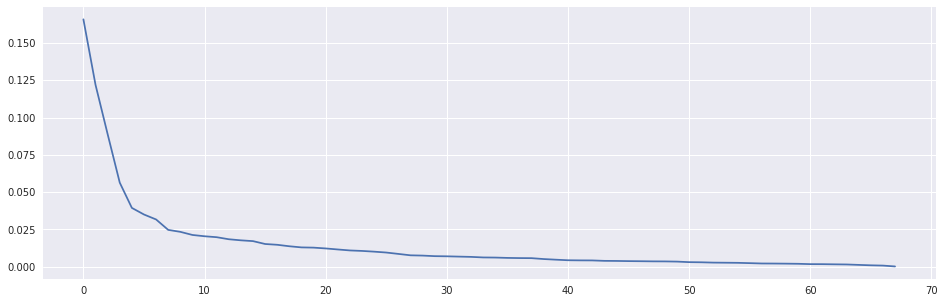

In [32]:
# Investigate the variance accounted for by each principal component.
plt.plot(pca.explained_variance_ratio_)

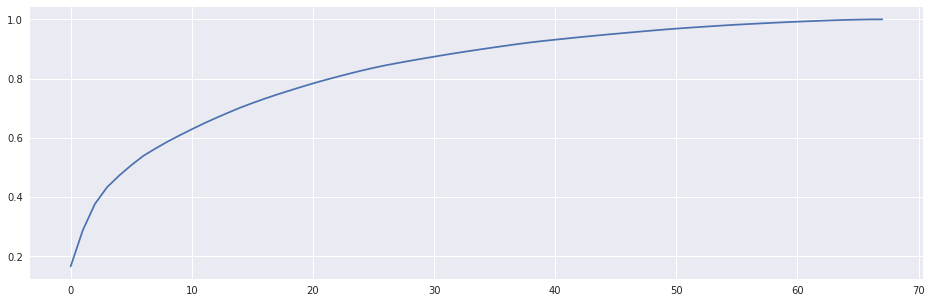

In [33]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

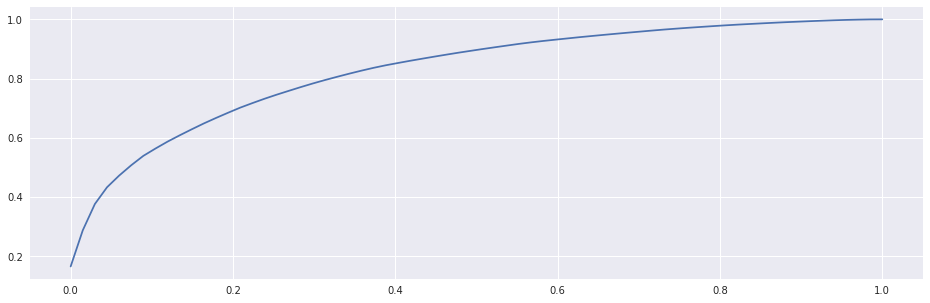

In [34]:
plt.plot(np.linspace(0, 1, len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))

In [35]:
print(list(enumerate(zip(np.linspace(0, 1, len(pca.explained_variance_ratio_)), 1-np.cumsum(pca.explained_variance_ratio_)))))

[(0, (0.0, 0.83415478709647473)), (1, (0.014925373134328358, 0.71219794707064688)), (2, (0.029850746268656716, 0.62331612138440418)), (3, (0.044776119402985072, 0.56694001674499916)), (4, (0.059701492537313432, 0.5275053910540578)), (5, (0.074626865671641784, 0.492501331541221)), (6, (0.089552238805970144, 0.46082385045817076)), (7, (0.1044776119402985, 0.43613180496119874)), (8, (0.11940298507462686, 0.41275170408009687)), (9, (0.13432835820895522, 0.39146285139523995)), (10, (0.14925373134328357, 0.37104409493204282)), (11, (0.16417910447761194, 0.35125429426888211)), (12, (0.17910447761194029, 0.33283732214247952)), (13, (0.19402985074626866, 0.31514914935672422)), (14, (0.20895522388059701, 0.29799176702726471)), (15, (0.22388059701492538, 0.28276309119781662)), (16, (0.23880597014925373, 0.26805942213840983)), (17, (0.2537313432835821, 0.25434896634289428)), (18, (0.26865671641791045, 0.24139537362234642)), (19, (0.28358208955223879, 0.22859911288912782)), (20, (0.2985074626865671

In [36]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_retain = 18 # Pareto level: Top 25% components explain 75% of variance
pca2 = PCA(n_components = n_retain)
azdias_processed_pca2 = pca2.fit_transform(azdias_processed_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Using PCA and plotting the cumulative sum of explained variance ratios, there appears to be two candidate values for the number of components we want to have. The first candidate value is where we see the "kink" in the chart at n=5-- the top 5 components account for 50% of the variance. The second candidate value is at n=18 which is the pareto-distribution value: the top 18 components, about 25% of the components, account for 75% of the variance. I am going with n=18 for now to be conservative. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [84]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
first_component = pca2.components_[0,:]
first_component_labeled = pd.Series(first_component, index=azdias_processed_final.columns)

first_component_labeled.iloc[(-first_component_labeled.abs()).argsort()]

MOBI_REGIO              -0.227586
PLZ8_ANTG3               0.221687
PLZ8_ANTG1              -0.219945
KBA05_ANTG1             -0.218354
PLZ8_BAUMAX              0.213616
FINANZ_MINIMALIST       -0.207475
PLZ8_ANTG4               0.206890
WEALTH                   0.200670
HH_EINKOMMEN_SCORE       0.200465
KBA05_GBZ               -0.199626
ORTSGR_KLS9              0.196474
EWDICHTE                 0.194777
KONSUMNAEHE             -0.167150
INNENSTADT              -0.163703
FINANZ_HAUSBAUER         0.162515
PLZ8_GBZ                -0.161363
LP_LEBENSPHASE_FEIN     -0.148774
PLZ8_ANTG2               0.147055
ARBEIT                   0.142196
LP_LEBENSPHASE_GROB     -0.134317
RELAT_AB                 0.134000
ANZ_HAUSHALTE_AKTIV      0.133387
BALLRAUM                -0.126424
FINANZ_SPARER            0.125819
KBA05_ANTG3              0.122189
MAINSTREAM_GENERATION    0.121648
LIFE_STAGE              -0.120305
KBA05_ANTG4              0.117602
GEBAEUDETYP_RASTER      -0.116964
GREEN_AVANTGAR

In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_component = pca2.components_[1,:]
second_component_labeled = pd.Series(second_component, index=azdias_processed_final.columns)

second_component_labeled.iloc[(-second_component_labeled.abs()).argsort()]

SEMIO_REL               -0.271367
ALTERSKATEGORIE_GROB     0.270255
SEMIO_ERL                0.246964
FINANZ_SPARER           -0.244625
SEMIO_TRADV             -0.240218
SEMIO_KULT              -0.238700
SEMIO_PFLICHT           -0.238217
FINANZ_VORSORGER         0.238141
FINANZ_UNAUFFAELLIGER   -0.227206
FINANZ_ANLEGER          -0.207338
SEMIO_FAM               -0.203230
SEMIO_LUST               0.190153
SEMIO_MAT               -0.174841
SEMIO_RAT               -0.173472
MAINSTREAM_GENERATION   -0.163241
RETOURTYP_BK_S           0.161917
ONLINE_AFFINITAET       -0.158322
SEMIO_KRIT               0.128309
SEMIO_KAEM               0.124690
SEMIO_SOZ               -0.117637
W_KEIT_KIND_HH           0.106066
ANREDE_KZ                0.104662
FINANZ_HAUSBAUER         0.100930
SEMIO_DOM                0.084388
EWDICHTE                 0.081408
FINANZ_MINIMALIST        0.081087
ORTSGR_KLS9              0.080332
SEMIO_VERT              -0.079605
PLZ8_ANTG3               0.073451
PLZ8_ANTG1    

In [86]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third_component = pca2.components_[2,:]
third_component_labeled = pd.Series(third_component, index=azdias_processed_final.columns)

third_component_labeled.sort_values()
third_component_labeled.iloc[(-third_component_labeled.abs()).argsort()]

ANREDE_KZ               -0.362592
SEMIO_VERT               0.342146
SEMIO_KAEM              -0.328124
SEMIO_DOM               -0.306294
SEMIO_KRIT              -0.269684
SEMIO_SOZ                0.256547
SEMIO_FAM                0.238664
SEMIO_RAT               -0.225835
SEMIO_KULT               0.221515
FINANZ_ANLEGER          -0.202832
SEMIO_ERL               -0.163862
FINANZ_MINIMALIST        0.163621
FINANZ_SPARER           -0.117858
RETOURTYP_BK_S           0.114893
MAINSTREAM_GENERATION   -0.113259
FINANZ_VORSORGER         0.110497
FINANZ_UNAUFFAELLIGER   -0.106334
ALTERSKATEGORIE_GROB     0.091835
SEMIO_PFLICHT           -0.091325
SEMIO_TRADV             -0.090862
W_KEIT_KIND_HH           0.086908
SEMIO_LUST               0.073988
GREEN_AVANTGARDE         0.066605
ORTSGR_KLS9              0.060438
EWDICHTE                 0.059198
ONLINE_AFFINITAET       -0.055460
SEMIO_REL                0.054343
INNENSTADT              -0.053261
PLZ8_ANTG1              -0.053077
PLZ8_BAUMAX   

### Discussion 2.3: Interpret Principal Components

First component is mainly composed of the following features:
* MOBI_REGIO, -0.227586: higher movement patterns
* PLZ8_ANTG3, 0.221687: higher share of 6-10 family houses in the PLZ8 region
* PLZ8_ANTG1, -0.219945: lower share of 1-2 family houses in the PLZ8 region
* KBA05_ANTG1, -0.218354: lower share of 1-2 family houses in the microcell
* PLZ8_BAUMAX, 0.213616: largest building types in PLZ8 region

The first component has to do with being more transient and living in higher-density multi-family housing.

Second component is mainly composed of the following features:
* SEMIO_REL, -0.271367: higher religiosity
* ALTERSKATEGORIE_GROB, 0.270255: older age
* SEMIO_ERL, 0.246964: less event-oriented
* FINANZ_SPARER, -0.244625: more stingy
* SEMIO_TRADV, -0.240218: more tradition-minded
* SEMIO_KULT, -0.238700: more cultural-minded
* SEMIO_PFLICHT, -0.238217: more dutiful
* FINANZ_VORSORGER, 0.238141 less financially prepared

The second component has to do with being older, more traditional, and more conservative with financial matters

The third component is mainly composed of the following features:
* ANREDE_KZ, -0.362592: more male
* SEMIO_VERT, 0.342146: less dreamful
* SEMIO_KAEM, -0.328124: more combative
* SEMIO_DOM, -0.306294: more dominant
* SEMIO_KRIT, -0.269684: more critical-minded
* SEMIO_SOZ, 0.256547: less socially-minded

The third component appears to represent the individual's level of aggression.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [40]:
# Over a number of different cluster counts...
cluster_counts = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30]

kmeans_dict = {}
distances = {}
for n in cluster_counts:
    # run k-means clustering on the data and...
    kmeans = KMeans(n)
    kmeans.fit(azdias_processed_pca2)
    kmeans_dict[n] = kmeans # save model
    
    # compute the average within-cluster distances.
    distances[n] = -kmeans.score(azdias_processed_pca2) # negative, because score gives the opposite of the distance    
    
    print(f"Finished kmeans for {n} clusters.")

Finished kmeans for 2 clusters.
Finished kmeans for 3 clusters.
Finished kmeans for 4 clusters.
Finished kmeans for 5 clusters.
Finished kmeans for 6 clusters.
Finished kmeans for 8 clusters.
Finished kmeans for 10 clusters.
Finished kmeans for 12 clusters.
Finished kmeans for 15 clusters.
Finished kmeans for 20 clusters.
Finished kmeans for 25 clusters.
Finished kmeans for 30 clusters.


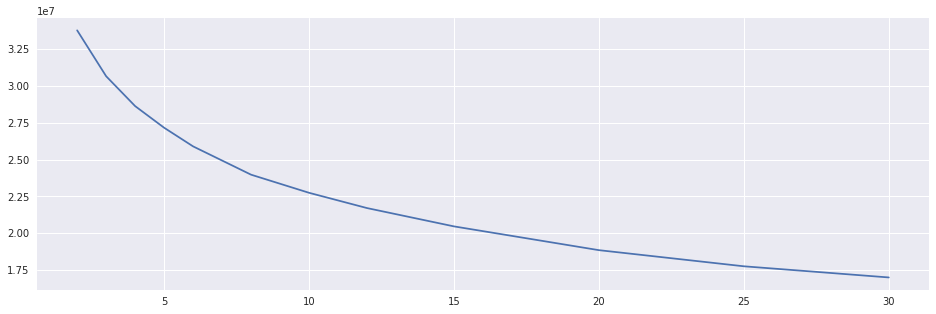

In [41]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(distances.keys(), distances.values())

In [50]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Kink at 20
n = 20
kmeans = kmeans_dict[n]
general_population_pred = kmeans.predict(azdias_processed_pca2)
print(general_population_pred)
print(general_population_pred.shape)

[13  7 16 ..., 18  9 10]
(798020,)


### Discussion 3.1: Apply Clustering to General Population

I decided to segment the population into 25 clusters since there appears to be an inflection point at that area.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [43]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [51]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)
print(f"Data cleaned! {customers_cleaned.shape} shape.")
customers_scaled = ss.transform(customers_cleaned)
print(f"Data scaled!")
customers_pca = pca2.transform(customers_scaled)
print(f"Data pca transformed!")
customers_cluster_pred = kmeans.predict(customers_pca)
print(f"KMeans complete!")

CJT_GESAMTTYP : [ 5.  1.  2.  6.  4.  3.  0.] : 7
FINANZTYP : [ 2.  6.  5.  3.  1.  4.] : 6
GFK_URLAUBERTYP : [  4.   1.   3.  10.   2.  11.   8.   5.   9.  12.   7.   6.   0.] : 13
LP_FAMILIE_FEIN : [  2.   1.   3.  10.   8.   6.  11.   9.   5.   7.   4.   0.] : 12
LP_FAMILIE_GROB : [ 2.  1.  3.  5.  4.  0.] : 6
LP_STATUS_FEIN : [ 10.   1.   9.   7.   6.   5.   8.   3.   4.   2.   0.] : 11
LP_STATUS_GROB : [ 5.  1.  4.  3.  2.  0.] : 6
NATIONALITAET_KZ : [ 1.  2.  3.  5.  4.  0.] : 6
SHOPPER_TYP : [ 3.  1.  0.  2.  5.  4.] : 6
ZABEOTYP : [ 3.  1.  2.  4.  6.  5.] : 6
GEBAEUDETYP : [ 1.  8.  2.  3.  4.  5.  6.] : 7
CAMEO_DEUG_2015_INT : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.] : 9
CAMEO_DEU_2015_INT : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.] : 44
Data cleaned! (191633, 68) shape.
Data scaled!
Data pca transfo

In [52]:
customers_cluster_pred

array([2, 6, 6, ..., 2, 6, 5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cluster_values = pd.DataFrame(
    {'general': [np.sum(general_population_pred == i)/(len(general_population_pred)) for i in range(20)], 
     'customer': [np.sum(customers_cluster_pred == i)/(len(customers_cluster_pred)) for i in range(20)]
    })

cluster_values

,general,customer
0,0.041508,0.005709
1,0.061042,0.018525
2,0.062545,0.223114
3,0.057046,0.028320
4,0.048442,0.029750
5,0.079734,0.112684
6,0.060740,0.065505
7,0.066933,0.075352
8,0.050721,0.003940
9,0.061210,0.004081


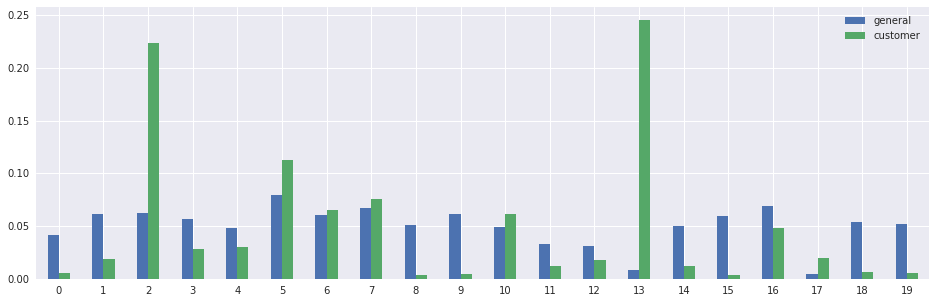

In [68]:
cluster_values.plot(kind='bar', rot=0)

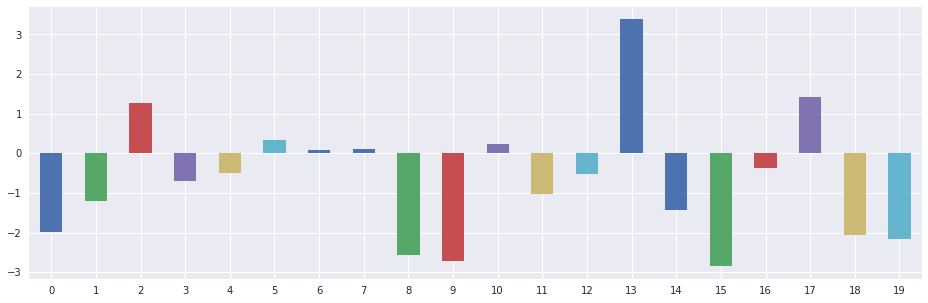

In [72]:
cluster_values['Customer representation'] = np.log(cluster_values['customer']/cluster_values['general'])
cluster_values['Customer representation'].plot(kind='bar', rot=0)

In [76]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Clusters 13, 17, and 2 are the most overrepresented in the customer data compared to the general population.
print(kmeans.cluster_centers_[13])
print(kmeans.cluster_centers_[17])
print(kmeans.cluster_centers_[2])

[ -0.27656295  -0.16522929   0.01203846   0.12485684   0.16180711
  -0.07033246   0.06123944  -0.02583563   0.03802743  -0.07329874
  -0.02091501  -0.1418199    0.15749787   0.19534866  -0.11464176
   0.31730176  10.78493598  -0.0694802 ]
[  0.03542244   1.58199709   1.17556535   1.98319156  -0.38922692
   1.58213757   1.20500583   3.50284156   2.19964243   1.7583526
   0.90547713   0.43935224   4.52715906   1.2494956   10.62946118
   3.66630194  -0.13921698   1.27988954]
[ -3.60130318e+00   3.20620120e-01   2.82294359e+00   2.06340003e+00
  -3.97449494e-01  -5.40940070e-02  -3.53497816e-01   1.03276927e-01
   8.27512130e-02  -6.52250084e-02  -1.83236033e-01  -1.54585436e-03
  -2.18861044e-02  -1.92933348e-01  -1.43826749e-01  -6.04505595e-02
  -9.58523146e-02  -6.53804400e-02]


In [87]:
# Cluster 13 is principally component 16; 
# cluster 17 is principally component 14; 
# and cluster 2 is a mix of components 0 (negative), 2, and 3.

components = [16, 14, 0, 2, 3]

for c in components:
    print(f"Component {c}: ")
    component = pca2.components_[c,:]
    component_labeled = pd.Series(component, index=azdias_processed_final.columns)

    print(component_labeled.iloc[(-component_labeled.abs()).argsort()][:5])
    print('-----------------')

Component 16: 
SOHO_KZ        0.996160
BALLRAUM       0.029543
WOHNLAGE      -0.028080
KBA05_ANTG4    0.027013
INNENSTADT     0.022334
dtype: float64
-----------------
Component 14: 
ANZ_TITEL           0.588250
ANZ_HH_TITEL        0.549670
FINANZ_HAUSBAUER   -0.197116
KBA05_ANTG2         0.192822
MIN_GEBAEUDEJAHR    0.165595
dtype: float64
-----------------
Component 0: 
MOBI_REGIO    -0.227586
PLZ8_ANTG3     0.221687
PLZ8_ANTG1    -0.219945
KBA05_ANTG1   -0.218354
PLZ8_BAUMAX    0.213616
dtype: float64
-----------------
Component 2: 
ANREDE_KZ    -0.362592
SEMIO_VERT    0.342146
SEMIO_KAEM   -0.328124
SEMIO_DOM    -0.306294
SEMIO_KRIT   -0.269684
dtype: float64
-----------------
Component 3: 
GREEN_AVANTGARDE         0.358958
AVANTGARDE_GENERATION    0.355385
WOHNLAGE                -0.253561
ORTSGR_KLS9              0.241669
EWDICHTE                 0.241002
dtype: float64
-----------------


In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Clusters 15, 9, and 8 are the most underrepresented in the customer data compared to the general population.
print(kmeans.cluster_centers_[15])
print(kmeans.cluster_centers_[9])
print(kmeans.cluster_centers_[8])

[ 2.49854334 -2.26849124 -3.19390272  0.04803796 -0.69823058 -0.32103565
 -0.26532757 -0.64583871  0.63749083 -0.56634962  0.06390607  0.03294936
  0.41397774  0.04384904  0.06547542 -0.06048919 -0.09196942 -0.27351968]
[ 4.59524466 -3.15736439  2.48634735 -0.16075619  0.12520167 -0.0700631
 -0.08811523  0.03148365  0.03863163  0.22399946 -0.3146053  -0.23950197
 -0.17189532  0.14972893 -0.10105602  0.05016133 -0.0989851  -0.08237247]
[  5.64913775e+00  -9.50193756e-01  -2.28915804e+00   8.32453834e-01
   5.13488537e-01   4.00642066e-01   7.74330691e-03   4.90952802e-01
   7.73160338e-01  -2.89241844e-01   1.55149806e-01  -5.12958799e-03
  -4.81545135e-01  -3.73218719e-01  -1.45827171e-01   1.23613189e-01
  -8.12928385e-02  -7.84106726e-02]


In [88]:
# All underrepresented clusters are principally components 0, 1, and 2.
# All underrepresented clusters are positive in component 0.
# All underrepresented clusters are negative in component 1.
# Cluster 15 and 8 are negative in component 2, whereas cluster 9 is positive in component 2.
components = [0, 1, 2]

for c in components:
    print(f"Component {c}: ")
    component = pca2.components_[c,:]
    component_labeled = pd.Series(component, index=azdias_processed_final.columns)

    print(component_labeled.iloc[(-component_labeled.abs()).argsort()][:5])
    print('-----------------')

Component 0: 
MOBI_REGIO    -0.227586
PLZ8_ANTG3     0.221687
PLZ8_ANTG1    -0.219945
KBA05_ANTG1   -0.218354
PLZ8_BAUMAX    0.213616
dtype: float64
-----------------
Component 1: 
SEMIO_REL              -0.271367
ALTERSKATEGORIE_GROB    0.270255
SEMIO_ERL               0.246964
FINANZ_SPARER          -0.244625
SEMIO_TRADV            -0.240218
dtype: float64
-----------------
Component 2: 
ANREDE_KZ    -0.362592
SEMIO_VERT    0.342146
SEMIO_KAEM   -0.328124
SEMIO_DOM    -0.306294
SEMIO_KRIT   -0.269684
dtype: float64
-----------------


### Discussion 3.3: Compare Customer Data to Demographics Data

**Clusters 13, 17, and 2 are the most overrepresented in the customer data compared to the general population.**
* Cluster 13 is principally component 16, which consists overwhelmingly of the SOHO_KZ column with value 0.996160.
* This implies that cluster 13 corresponds to individuals who have a small office or home office.
* Cluster 17 is principally component 14, which consists mainly of the following: 
  * ANZ_TITEL, 0.588250: higher number of professional academic title holders in household
  * ANZ_HH_TITEL, 0.549670 higher number of professional academic title holders in building
* This implies that cluster 17 corresponds to individuals in highly educated environments.
* Cluster 2 is a mix of components 0 (negative), 2, and 3. Components 0 and 2 have already been analyzed:
  * Being negative in component 0 implies cluster 2 individuals are less transient and living in lower-density situations.
  * Being positive in component 2 implies cluster 2 individuals are more likely to be male.
* Cluster 2 is positive in component 3, which consists of the following: 
  * GREEN_AVANTGARDE, 0.358958: likely to have membership in environmental sustainability as part of youth
  * AVANTGARDE_GENERATION, 0.355385

**Clusters 15, 9, and 8 are the most underrepresented in the customer data compared to the general population.**
* All underrepresented clusters are principally components 0, 1, and 2, which were previously analyzed.
* All underrepresented clusters are positive in component 0, implying the clustered individuals are more transient and living in higher-density multi-family housing.
* All underrepresented clusters are negative in component 1, implying the clustered individuals are younger, less traditional, and less conservative with financial matters
* Underrepresented clusters are dividend in component 2, which corresponds to masculinity and aggression. Hence we cannot draw inferences about this characteristic.

### Conclusion
This mail-order company tends to cater to educated office workers who are more likely to be male, with a small tendency to be environmentally conscious. Individuals who are younger, more transient, and less traditional tend to be underrepresented with this mail-order company.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.